In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/CVENG-8160/MODULE 03'

/content/drive/MyDrive/CVENG-8160/MODULE 03


In [3]:
ls

Data/  LECTURE_DATA_LOADERS.ipynb  TORCH_INTRODUCTION.ipynb


In [4]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
class traffic_sign(Dataset):
    def __init__(self, *args):

        # initialize dataset variables here
        print ('initialize')

    def __len__(self):
        # returns the length of the dataset
        return None

    def __getitem__(self, index):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        return image, label

In [5]:
class traffic_sign(Dataset):
    def __init__(self, root_dir ):

        # initialize dataset variables here
        # self.root = root_dir
        self.root = Path(root_dir)

        self.df = pd.DataFrame(columns = ['image_names','class_label'])

        #go through this
        for fldr in self.root.iterdir():
          img_names = []
          if fldr.is_dir():
            img_names = img_names + list(fldr.glob('*.ppm'))

          img_names = [i for i in img_names]
          df_cur = pd.DataFrame(img_names,columns = ['image_names'])
          df_cur['class_label'] = fldr.name
          self.df = pd.concat([self.df, df_cur],axis=0)

        self.df = self.df.sample(frac=1) # does shuffling
        self.image_names = list(self.df['image_names'].values)
        self.class_label = list(self.df['class_label'].values)


    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        image_data = io.imread(image)
        # image_np = Image.fromarray(image_data)

        label = self.class_label[idx]

        sample = {'image': image_data, 'label': label}

        return sample

In [9]:
traffic_sign_dataset = traffic_sign('Data')

In [10]:
traffic_sign_dataset.__len__()

4668

0 (102, 97, 3) 00014
1 (32, 33, 3) 00013
2 (45, 44, 3) 00029
3 (96, 101, 3) 00013
4 (58, 64, 3) 00013
5 (34, 36, 3) 00029
6 (81, 94, 3) 00013
7 (41, 40, 3) 00014


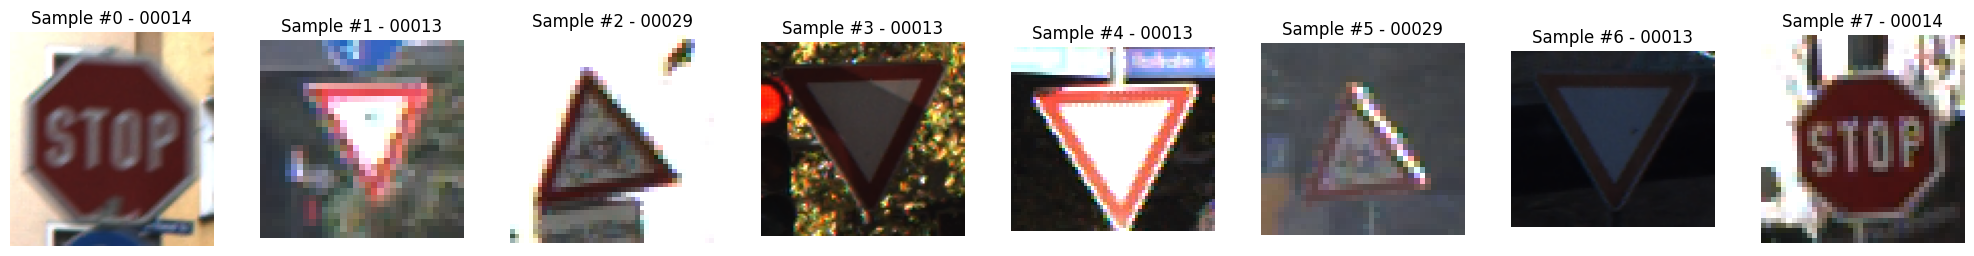

In [12]:
fig = plt.figure(figsize=(20,20))
ncols = 8
for i, sample in enumerate(traffic_sign_dataset):
  print(i, sample['image'].shape, sample['label'])
  ax = plt.subplot(1, ncols, i + 1)
  plt.tight_layout()
  ax.set_title('Sample #{} - {}'.format(i, sample['label']))
  ax.axis('off')
  # show_landmarks(**sample)
  plt.imshow(sample['image'])

  if i == ncols-1:
      plt.show()
      break

In [13]:
## transform data
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': labels}

In [21]:
scale = Rescale((128, 128))

In [22]:
out_img = scale(traffic_sign_dataset[5])

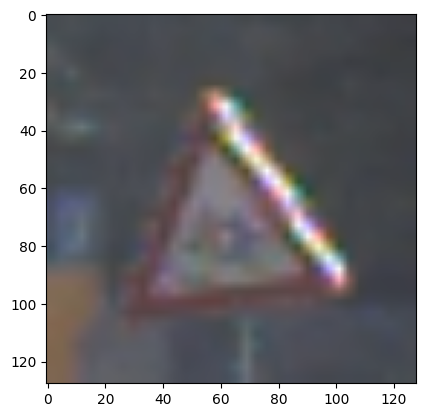

In [23]:
plt.imshow(out_img['image'])

In [37]:
## write a class to flip the image from left  to right
class Flip(object):
    """Flip left to right

    Args:
        flip (int): lr or ud.
    """

    def __init__(self, flip):
      assert isinstance(flip, int)
      self.flip = flip

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        img = np.flip(image, self.flip)

        return {'image': img, 'label': labels}

## write a class to convert image to tensor
import torch
class To_Tensor(object):
    """Convert image to tensor

    Args:
    """

    def __init__(self):
      pass

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        img = torch.from_numpy(image)
        img = img.transpose(1, 2).transpose(0, 1)

        return {'image': img, 'label': labels}

Flip
Rescale
Compose


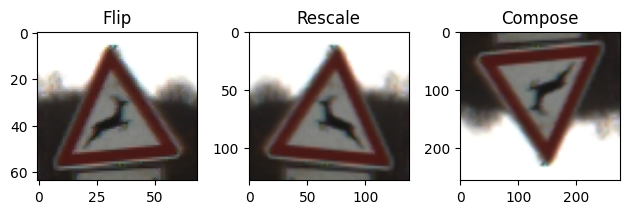

In [39]:
import time
composed = transforms.Compose([Rescale(256), Flip(0)])
for i,trnsfm in enumerate([Flip(1), Rescale(128),composed]):
  print (type(trnsfm).__name__)
  # print (trnsfm(traffic_sign_dataset[500]))

  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(trnsfm(traffic_sign_dataset[500])['image'])
  plt.tight_layout()
  ax.set_title(type(trnsfm).__name__)

In [31]:
tensorize = To_Tensor()
out_img = tensorize(traffic_sign_dataset[5])
print(out_img['image'].shape)

torch.Size([34, 36, 3])
torch.Size([3, 34, 36])


In [ ]:
class TrafficSignDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        # initialize dataset variables here
        # self.root = root_dir
        self.root = Path(root_dir)
        self.transform = transform

        self.df = pd.DataFrame(columns = ['image_names','class_label'])

        for fldr in self.root.iterdir():
          img_names = []
          if fldr.is_dir():
            img_names = img_names + list(fldr.glob('*.ppm'))

          img_names = [i for i in img_names]
          df_cur = pd.DataFrame(img_names,columns = ['image_names'])
          df_cur['class_label'] = fldr.name
          self.df = pd.concat([self.df, df_cur],axis=0)

        self.df = self.df.sample(frac=1)
        self.image_names = list(self.df['image_names'].values)
        self.class_label = list(self.df['class_label'].values)


    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        image_data = io.imread(image)
        # image_np = Image.fromarray(image_data)

        label = self.class_label[idx]

        sample = {'image': image_data, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
compose_transforms = transforms.Compose([Rescale((256,256)), Flip(0)])
traffic_obj = TrafficSignDataset('data/traffic_signs_class',transform=compose_transforms)

In [ ]:
for i,ts in enumerate(traffic_obj):
  print (ts['image'].shape)
  if i == 5:
    break

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
